# Notebook version of NSGA-II constrained, without scoop

In [1]:
%matplotlib inline

In [4]:
#!/usr/bin/env python

#    This file is part of DEAP.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import array
import random
import json

import time

import numpy

from math import sqrt, cos, atan

#from scoop import futures

from deap import algorithms
#from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence
from deap import creator
from deap import base, tools
from xdeap import fitness_with_constraints # Chris' custom routines

from deap.benchmarks.tools import diversity, convergence, hypervolume


creator.create("FitnessMin", fitness_with_constraints.FitnessWithConstraints, weights=(-1.0, -1.0, 1.0, 1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

NDIM = 2
N_CONSTRAINTS = 2

#BOUND_LOW, BOUND_UP = [0.1, 0.0] , [1.0, 1.0]
def CONSTR(individual):
    #time.sleep(.01)
    x1=individual[0]
    x2=individual[1]
    objectives =  (x1, (1.0+x2)/x1)
    constraints = (x2+9*x1-6.0, -x2+9*x1-1.0)
    return (objectives, constraints)

BOUND_LOW, BOUND_UP = [0.0, 0.0], [3.14159, 3.14159]  
def TNK(individual):    
    x1=individual[0]
    x2=individual[1]
    objectives =  (x1, x2)
    constraints = (x1**2+x2**2-1.0 - 0.1*cos(16*atan(x1/x2)), 0.5-(x1-0.5)**2-(x2-0.5)**2 )
    return (objectives, constraints)

#BOUND_LOW, BOUND_UP = [-20.0, -20.0], [20.0, 20.0]  
def SRN(individual):    
    x1=individual[0]
    x2=individual[1]
    objectives = ( (x1-2.0)**2 + (x2-1.0)**2+2.0,  9*x1-(x2-1.0)**2 )
    constraints = (225.0-x1**2-x2**2, -10.0 -x1 - 3*x2 )
    return (objectives, constraints)




toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# scoop map function
#toolbox.register('map', futures.map)
toolbox.register('map', map) 
    
#toolbox.register("evaluate", CONSTR)
toolbox.register("evaluate", TNK)
#toolbox.register("evaluate", SRN)

toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)

def main(seed=None):
    random.seed(seed)

    NGEN = 200
    MU = 100
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    pop = toolbox.population(n=MU)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    evaluate_result = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, evaluate_result):
        ind.fitness.values = fit[0]
        ind.fitness.cvalues = fit[1]
        ind.fitness.n_constraints = len(fit[1])


    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # Begin the generational process
    for gen in range(1, NGEN):
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
            
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit[0]
            ind.fitness.cvalues = fit[1]
            ind.fitness.n_constraints = len(fit[1])

        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream, hypervolume(pop, [1.0,1.0]))
        

    return pop, logbook

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	evals	std                    	min                    	avg                    	max                    
0  	100  	[0.86431607 0.82548571]	[0.04609565 0.13449313]	[1.55529378 1.65524009]	[3.08098905 3.07928528]
1  	100  	[0.50727815 0.54214588]	[0.10426755 0.08450199]	[1.15863745 1.18481818]	[2.16762462 2.10002413] 0.09139362188374213
2  	100  	[0.37563072 0.41200833]	[0.14569736 0.08450199]	[0.99452705 0.91879987]	[1.5298802  1.56170597] 0.1317175110048399
3  	100  	[0.31733242 0.36009488]	[0.112385   0.02132635]	[0.81806468 0.84670802]	[1.30448644 1.29084675] 0.14672751328891095
4  	100  	[0.30081364 0.29748355]	[0.112385   0.14068652]	[0.68889969 0.82070483]	[1.16864751 1.1791499 ] 0.1584443644731873
5  	100  	[0.33835941 0.31100937]	[0.07668067 0.12740678]	[0.70036067 0.71932414]	[1.14790418 1.16499094] 0.1622935061410179
6  	100  	[0.33889887 0.32055377]	[0.05485062 0.12209134]	[0.7339598  0.62838489]	[1.14481008 1.08045874] 0.16253923044906032
7  	100  	[0.32948646 0.3171557 ]	[

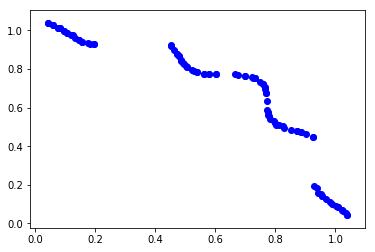

In [5]:
#if __name__ == "__main__":
#    #optimal_front = json.load(open("pareto_front/zdt4_front.json"))
#    # Use 500 of the 1000 points in the json file
#    #optimal_front = sorted(optimal_front[i] for i in range(0, len(optimal_front), 2))
    
pop, stats = main()
pop.sort(key=lambda x: x.fitness.values)

print(stats)
#print("Convergence: ", convergence(pop, optimal_front))
#print("Diversity: ", diversity(pop, optimal_front[0], optimal_front[-1]))

import matplotlib.pyplot as plt
import numpy
 
front = numpy.array([ind.fitness.values for ind in pop])
#optimal_front = numpy.array(optimal_front)
#plt.scatter(optimal_front[:,0], optimal_front[:,1], c="r")
plt.scatter(front[:,0], front[:,1], c="b")
plt.axis("tight")
plt.show()

# Hypervolume

In [6]:
from deap.benchmarks.tools import diversity, convergence, hypervolume

In [7]:
print("Final population hypervolume is %f" % hypervolume(pop, [1.0,1.0]))

Final population hypervolume is 0.229998
